In [1]:
#xraydeg_v4
#pbi2 to <100> ratios normalized and overlapped
#combo of a bunch of smaller pieces of code. apologies if it is messy

In [2]:
#%%
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize 
import pandas as pd

# %%
#Defining all functions that will be used in program
def csv_to_np(filename):
    #filemane is a csv of xrd data with the first column being two-theta 
    # and subsequent columns being xray intensities
    data = pd.read_csv(filename)
    return(np.array(data))

def norm(x):
    #returns normalized version of an array
    return x/np.nanmax(x)

def two_to_q(two_theta, wave):
    #two_theta is a 1D array of two_theta angles
    #wave is the X-ray energy in angstroms
    rad_theta = two_theta/2*np.pi/180
    q = 4*np.pi*np.sin(rad_theta)/wave
    return q

def find_nearest(array, value):
    #array is a 1D vector of two_theta or q values
    #value is the specific angle or q for which you want the index
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def trim_data(x, data, limit1, limit2):
    #x is a 1D array of two theta or q values
    #data is an array of x-ray intensities
    #limit1 and limit2 are what you'd like to trime your data to 
    set1 = find_nearest(x,limit1)
    set2 = find_nearest(x,limit2)
    return x[set1:set2], data[set1:set2,:]

def back_subtract(x, data, length):
    #x is a 1D array of two theta or q values
    #data is an array of x-ray intensities
    #length is the number of values on the edges of the data you want to use to create a linear background 
    x_linear = np.hstack((x[0:length], x[-length:-1])) #I'm taking the starting and ending values
    data_linear = np.hstack((data[0:length], data[-length:-1])) #We'll use these to fit a straight line
    slope, intercept = np.polyfit(x_linear, data_linear, 1) #Do linear fit
    back = slope*x+intercept 
    data_correct=(data-back)
    return data_correct

def gaussian(x, a, b, c): 
    #generic gaussian curve, for XRD analysis:
    #x is a 1D array of two theta or q values
    #a is the max intensity of the peak and representative of crystalling
    #b is the peak position and 
    # c is the FWHM
    return a*np.exp(-(x - b)**2/(2*c**2))

def normal_gaussian(x, a, b): 
    #nomralized gaussian curve for XRD analysis:
    #x is a 1D array of two theta or q values
    #a is the peak position and 
    #b is the FWHM
    return 2/b*sqrt(ln(2)/math.pi)*np.exp(-4*ln(2)/b**2*(x - a)**2)

def two_gaussians(x, a1, b1, c1, a2, b2, c2):
        return (gaussian(x, a1, b1, c1) +
            gaussian(x, a2, b2, c2))

def multi_gaussian(x, guesses):
    #NOTE This function does not work with curve fitting yet TBD
    # x is 1D array of 2-theta or q values for our fitting
    # trips is an array of fits i.e. [[200, 1, .01], [150, 1.05. .02]]
    peaks = [gaussian(x, fit[0], fit[1], fit[2]) for fit in guesses]
    return np.sum(peaks, axis=0)

# Define three peak fitting
def three_gaussians(x, a1, b1, c1, a2, b2, c2, a3, b3, c3):
    return (gaussian(x, a1, b1, c1) +
            gaussian(x, a2, b2, c2)+ #this would be your initial peak center in Q
            gaussian(x, a3, b3, c3))
def normal_gaussian(x, a, b, c): 
    #nomralized gaussian curve for XRD analysis:
    #x is a 1D array of two theta or q values
    #a is the instensity 
    #b is the peak position and 
    #c is the variance (FWHM = sqrt(2ln2)*c)
    return a/(c*np.sqrt(2*math.pi))*np.exp(-(x - b)**2/(2*c**2))

def lorentz(x, a, b, c):
    #generic lorentzian curve, for xrd analysis
    #x is a 1D array of two theta or q values
    #a is the max intensity of the peak and representative of crystalling
    #b is the peak position and 
    # c is the FWHM
    return a/np.pi*((c/2)/((x-b)**2+(c/2)**2))

def pvoigt(x, e, a, b, c):
    #pseudovoigt curve common in xrd analysis
    #linear combination of lorentzian and gaussian curves
    #e is the fraction that is lorentzian
    c_g = c/(2*np.sqrt(2*np.log(2)))
    return e*lorentz(x, a, b, c) + (1-e)*normal_gaussian(x,a,b,c_g)
    
def mult_pvoigt(x, e, a, b, c, a2, b2, c2, a3, b3, c3):
    return pvoigt(x, e, a, b, c) + pvoigt(x, e, a2, b2, c2) +  pvoigt(x, e, a3, b3, c3) 

def q_to_a(center,plane):
    #center is the center of an xrd peak
    #plane is a list of the formal [h,k,l]
    a = 2*math.pi*math.sqrt(plane[0]**2+plane[1]**2+plane[2]**2)/center
    return a

def num_files(data):
    #data is the file you are currently analyzing
    #returns columns of data (i.e. frames for XRD data from SSRL)
    size = data.shape
    return size[1]

def q_to_chem(center,plane):
    #center is the center of an xrd peak
    #plane is a list of the formal [h,k,l]
    #takes peak position in q and converts it to bromine percentage
    #using linear fit for bromine fraction on lattice spacing
    slope = -0.3637
    intercept = 6.2841
    br_frac = 1/slope*(q_to_a(center,plane)-intercept)
    return br_frac

def frames_to_time(x,speed,start_lag):
    #x=num_frames
    #speed=shutter speed in s
    #start_lag=t at x=0
    seconds=np.array([(x*speed)+ start_lag])
    return seconds

def perovtopbi2(q, intensity):
    #array is a 1D vector of  q values
    #intensity is a 1D vector of perovskite intensities
    leadiodide_q = 0.85 #rough q of lead iodide peak 
    pad = 5 #number of points around leadiodide_q to look for true max
    peak = find_nearest(q,leadiodide_q)
    leadiodide_inensity = max(intensity[peak-pad:peak+pad])
    ratio = max(intensity)/leadiodide_inensity
    return ratio


<Figure size 360x288 with 0 Axes>

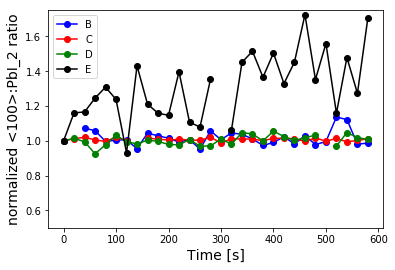

In [11]:
#version for also looking at peak areas
from scipy.optimize import curve_fit

#%% Import Data
perov_importB = csv_to_np('/Volumes/GoogleDrive/Shared drives/Wellesley Solar/Current Projects/ Hoke Effect/Xraydeg/integrations 020121/B1_xraydeg_020121.csv')
perov_importC = csv_to_np('/Volumes/GoogleDrive/Shared drives/Wellesley Solar/Current Projects/ Hoke Effect/Xraydeg/integrations 020121/C1_xraydeg_020121.csv')
perov_importD = csv_to_np('/Volumes/GoogleDrive/Shared drives/Wellesley Solar/Current Projects/ Hoke Effect/Xraydeg/integrations 020121/D1_xraydeg_020121.csv')
perov_importE = csv_to_np('/Volumes/GoogleDrive/Shared drives/Wellesley Solar/Current Projects/ Hoke Effect/Xraydeg/integrations 020121/E1_xraydeg_020121.csv')

imports = [perov_importB, perov_importC,perov_importD, perov_importE] #perov_importB,
labels = ['B','C','D','E'] 
colors = ['b-o','r-o','g-o', 'k-o']
#set up figure
plt.figure(num = 1, figsize=(5,4))
fig1,ax1 = plt.subplots()
ax1.set_xlabel('Time [s]',size=14) #Define x-axis label
ax1.set_ylabel('normalized <100>:PbI_2 ratio',size=14)#Define y-axis label
ax1.set_ylim(0.5,1.75)
#initiate guesses for gaussians (individually tested)
p_b1 = [60, 1.025, 0.005]
l_b1=[1.5, 0.895, 0.009]
p_c1 = [100, 1.02, 0.01]
l_c1 = [1.5, 0.895, 0.009]
p_d1 = [250, 1.041, 0.02]
l_d1=[2.0, 0.905, 0.009]
p_e1= [80, 1.05, 0.03]
l_e1=[0.5, 0.901, 0.01]
p_p0=[p_b1,p_c1,p_d1,p_e1]
l_p0=[l_b1,l_c1,l_d1,l_e1]
#iteratively run through imports
count = 0
for imp in imports:
    #%% Covert to Q
    q = two_to_q(imp[:,0],0.982381)
    perov = imp[:,1:] #seperate XRD intensities from rest of data 
    #%% #Trim to isolate first peaks and Remove Background
    miller = [1, 0, 0] #peak you are trying to capture
    q_1 = 0.8
    q_2 = 1.15
    q_n, perov_sub = trim_data(q,perov,q_1,q_2)
    perov_fit = perov_sub
    files = num_files(perov_sub)
    for file in range(files): 
        perov_fit[:,file] = back_subtract(q_n,perov_sub[:,file],10) #remove background from that file
    # %% make a array of values of peak areas for lead and <1,0,0> peak
    files = num_files(perov)
    time = np.zeros(files)
    area_lead = np.zeros(files)
    area_100 = np.zeros(files)

    #a is the max intensity of the peak and representative of crystalling
    #b is the peak position and 
    # c is the FWHM

    #gaussian fitting of <100> peak
    perov_p0 = p_p0[count]
    li_p0 = l_p0[count]
    for j in range(files):
        time[j] = j*20
        p_popt, p_pcov = curve_fit(gaussian, np.array(q_n), perov_fit[:,j], perov_p0)
        area_100[j] = sum(gaussian(q_n,p_popt[0],p_popt[1],p_popt[2]))
    #gaussian fitting of lead iodide peak
        li_popt, li_pcov = curve_fit(gaussian, np.array(q_n), perov_fit[:,j], li_p0)
        area_lead[j] = sum(gaussian(q_n,li_popt[0],li_popt[1],li_popt[2]))
    
    ratio = area_100/area_lead

    #%%use grubbs test to remove outliers in ratio
    g_min = min(ratio)
    g_max = max(ratio)
    g_calc_min = abs(g_min-np.mean(ratio))/np.std(ratio)
    g_calc_max=abs(g_max-np.mean(ratio))/np.std(ratio)
    if g_calc_min > 1.96:
        ind_min = np.where(ratio == g_min)
        ratio[ind_min]= None
    else:
        pass
    if g_calc_max > 1.96:
        ind_max = np.where(ratio == g_max)
        ratio[ind_max]= None
    else:
        pass
    # %% Plot result over time
    norm = ratio/ratio[0]
    plt.plot(time, norm, colors[count], label=labels[count])
    
    count = count +1

ax1.legend()


<Figure size 360x288 with 0 Axes>

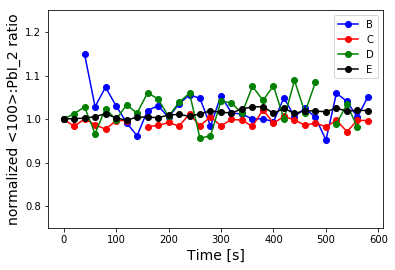

In [31]:
#version for also looking at peak heights only
from scipy.optimize import curve_fit

#%% Import Data
perov_importB = csv_to_np('/Volumes/GoogleDrive/Shared drives/Wellesley Solar/Current Projects/ Hoke Effect/Xraydeg/integrations 020121/B1_xraydeg_020121.csv')
perov_importC = csv_to_np('/Volumes/GoogleDrive/Shared drives/Wellesley Solar/Current Projects/ Hoke Effect/Xraydeg/integrations 020121/C1_xraydeg_020121.csv')
perov_importD = csv_to_np('/Volumes/GoogleDrive/Shared drives/Wellesley Solar/Current Projects/ Hoke Effect/Xraydeg/integrations 020121/D1_xraydeg_020121.csv')
perov_importE = csv_to_np('/Volumes/GoogleDrive/Shared drives/Wellesley Solar/Current Projects/ Hoke Effect/Xraydeg/integrations 020121/E1_750bin.csv')

imports = [perov_importB, perov_importC,perov_importD, perov_importE] 
labels = ['B','C','D','E'] 
colors = ['b-o','r-o','g-o', 'k-o']
#set up figure
plt.figure(num = 1, figsize=(5,4))
fig1,ax1 = plt.subplots()
ax1.set_xlabel('Time [s]',size=14) #Define x-axis label
ax1.set_ylabel('normalized <100>:PbI_2 ratio',size=14)#Define y-axis label
ax1.set_ylim(0.75,1.25)
#initiate guesses for 

#iteratively run through imports
count = 0
for imp in imports:
    #%% Covert to Q
    q = two_to_q(imp[:,0],0.982381)
    perov = imp[:,1:] #seperate XRD intensities from rest of data 
    #%% #Trim to isolate first peaks and Remove Background
    miller = [1, 0, 0] #peak you are trying to capture
    q_1 = 0.8
    q_2 = 1.15
    q_n, perov_sub = trim_data(q,perov,q_1,q_2)
    perov_fit = perov_sub
    files = num_files(perov_sub)
    for file in range(files): 
        perov_fit[:,file] = back_subtract(q_n,perov_sub[:,file],10) #remove background from that file
    # %% make a array of values of peak areas for lead and <1,0,0> peak
    files = num_files(perov)
    time = np.zeros(files)
    lead = np.zeros(files)
    max_100 = np.zeros(files)
    for frame in range(files): 
        time[frame] = frame*20
        current = perov_fit[:,frame]
        lead[frame]=max(current[20:60])
        max_100[frame]=max(current[60:118])
    ratio = max_100/lead
     #%%use grubbs test to remove outliers in ratio
    g_min = min(ratio)
    g_max = max(ratio)
    g_calc_min = abs(g_min-np.mean(ratio))/np.std(ratio)
    g_calc_max=abs(g_max-np.mean(ratio))/np.std(ratio)
    if g_calc_min > 1.96:
        ind_min = np.where(ratio == g_min)
        ratio[ind_min]= None
    else:
        pass
    if g_calc_max > 1.96:
        ind_max = np.where(ratio == g_max)
        ratio[ind_max]= None
    else:
        pass
    # %% Plot result over time
    norm = ratio/ratio[0]
    plt.plot(time, norm, colors[count], label=labels[count])
    
    count = count +1

ax1.legend()

